# Ad Classification Model using TensorFlow

This notebook demonstrates how to:
1. Load a vocabulary from a JSON file
2. Create a custom tokenizer using the vocabulary
3. Load a corpus from a JSON file
4. Preprocess the text data
5. Build and train a classification model using TensorFlow
6. Save the model for use with TensorFlow.js

## 1. Setup and Imports

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import json


import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

2025-03-28 11:25:36.954364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-28 11:25:36.969795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-28 11:25:36.974749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-28 11:25:36.986207: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-28 11:25:37.698057: W tensorflow/compiler/tf2

TensorFlow version: 2.17.0


## 2. Custom Tokenizer with JSON Vocabulary

In [2]:
class CustomTokenizer:
    def __init__(self, vocab_file=None):
        self.word_index = {}
        self.index_word = {}
        self.num_words = 0
        self.oov_token = '<OOV>'  # Out of vocabulary token
        self.pad_token = '<PAD>'
        
        # If vocab file is provided, load it
        if vocab_file:
            self.load_vocabulary(vocab_file)
        else:
            # Initialize with special tokens
            self.word_index = {self.pad_token: 0, self.oov_token: 1}
            self.index_word = {0: self.pad_token, 1: self.oov_token}
            self.num_words = 2
    
    def load_vocabulary(self, vocab_file):
        """Load vocabulary from a JSON file"""
        with open(vocab_file, 'r') as f:
            vocab_data = json.load(f)
            
        # Check if the vocabulary is in word->index format or a list of words
        if isinstance(vocab_data, dict):
            self.word_index = vocab_data
            # Make sure special tokens are included
            if self.pad_token not in self.word_index:
                self.word_index[self.pad_token] = 0
            if self.oov_token not in self.word_index:
                self.word_index[self.oov_token] = 1
        elif isinstance(vocab_data, list):
            # Initialize with special tokens
            self.word_index = {self.pad_token: 0, self.oov_token: 1}
            # Add words from list
            for i, word in enumerate(vocab_data):
                self.word_index[word] = i + 2  # +2 for special tokens
        
        # Create reverse mapping
        self.index_word = {v: k for k, v in self.word_index.items()}
        self.num_words = len(self.word_index)
        
        print(f"Loaded vocabulary with {self.num_words} words")
    
    def fit_on_texts(self, texts):
        """Create vocabulary from texts"""
        word_counts = {}
        
        # Count word frequencies
        for text in texts:
            for word in self._text_to_word_sequence(text):
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
        
        # Sort words by frequency (most common first)
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Initialize with special tokens
        self.word_index = {self.pad_token: 0, self.oov_token: 1}
        
        # Add words to vocabulary
        for i, (word, _) in enumerate(sorted_words):
            self.word_index[word] = i + 2  # +2 for special tokens
        
        # Create reverse mapping
        self.index_word = {v: k for k, v in self.word_index.items()}
        self.num_words = len(self.word_index)
        
        print(f"Created vocabulary with {self.num_words} words")
    
    def _text_to_word_sequence(self, text):
        """Convert text to lowercase and split into words"""
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Split into words
        return text.split()
    
    def texts_to_sequences(self, texts):
        """Convert texts to sequences of word indices"""
        sequences = []
        
        for text in texts:
            words = self._text_to_word_sequence(text)
            sequence = []
            
            for word in words:
                # Use word index if in vocabulary, otherwise use OOV token
                if word in self.word_index:
                    sequence.append(self.word_index[word])
                else:
                    sequence.append(self.word_index[self.oov_token])
            
            sequences.append(sequence)
        
        return sequences
    
    def sequences_to_texts(self, sequences):
        """Convert sequences of word indices to texts"""
        texts = []
        
        for sequence in sequences:
            words = []
            
            for idx in sequence:
                if idx in self.index_word:
                    words.append(self.index_word[idx])
                else:
                    words.append(self.oov_token)
            
            texts.append(' '.join(words))
        
        return texts
    
    def save_vocabulary(self, filepath):
        """Save vocabulary to a JSON file"""
        with open(filepath, 'w') as f:
            json.dump(self.word_index, f)
        
        print(f"Saved vocabulary to {filepath}")

## 3. Loading the Corpus from JSON

In [3]:
def load_corpus(corpus_file):
    """Load corpus from a JSON file"""
    with open(corpus_file, 'r') as f:
        corpus_data = json.load(f)
    
    # Expected format: List of dictionaries with 'text' and 'label' keys
    # Or a dictionary with 'texts' and 'labels' keys
    
    texts = []
    labels = []
    
    if isinstance(corpus_data, list):
        for item in corpus_data:
            texts.append(item.get('text', ''))
            labels.append(1 if item.get('label', '').lower() == 'ads' else 0)
    elif isinstance(corpus_data, dict):
        texts = corpus_data.get('texts', [])
        raw_labels = corpus_data.get('labels', [])
        labels = [1 if label.lower() == 'ads' else 0 for label in raw_labels]
    
    print(f"Loaded corpus with {len(texts)} samples")
    print(f"Label distribution: {sum(labels)} ads, {len(labels) - sum(labels)} not ads")
    
    return texts, labels

# For demonstration purposes, let's create a sample corpus if not available
def create_sample_corpus(filepath, num_samples=1000):
    """Create a sample corpus for demonstration"""
    if os.path.exists(filepath):
        print(f"Corpus file {filepath} already exists. Skipping creation.")
        return
    
    # Sample ad texts
    ad_prefixes = [
        "Buy now", "Limited offer", "Discount", "Sale", "Free shipping",
        "Best deal", "Don't miss", "Special price", "Act now", "New arrival"
    ]
    
    ad_products = [
        "shoes", "smartphone", "laptop", "clothes", "watch",
        "headphones", "camera", "TV", "furniture", "kitchen appliances"
    ]
    
    ad_suffixes = [
        "at our store", "online", "with free delivery", "today only",
        "while supplies last", "for a limited time", "with 50% off",
        "and get a free gift", "before they're gone", "and save money"
    ]
    
    # Sample non-ad texts
    non_ad_prefixes = [
        "I think", "Today I", "The weather is", "My friend", "Yesterday",
        "The movie was", "I read", "Did you know", "I'm planning", "I heard"
    ]
    
    non_ad_topics = [
        "went to the park", "watched a movie", "read a book", "cooked dinner",
        "visited my family", "learned something new", "had a great day",
        "started a new hobby", "met an old friend", "worked on a project"
    ]
    
    non_ad_suffixes = [
        "and enjoyed it", "for the first time", "with my friends", "yesterday",
        "last weekend", "after work", "during my vacation", "in the morning",
        "before going to sleep", "and it was fun"
    ]
    
    corpus = []
    
    # Generate ad samples (roughly half)
    for _ in range(num_samples // 2):
        prefix = np.random.choice(ad_prefixes)
        product = np.random.choice(ad_products)
        suffix = np.random.choice(ad_suffixes)
        text = f"{prefix} {product} {suffix}"
        corpus.append({"text": text, "label": "ads"})
    
    # Generate non-ad samples
    for _ in range(num_samples - len(corpus)):
        prefix = np.random.choice(non_ad_prefixes)
        topic = np.random.choice(non_ad_topics)
        suffix = np.random.choice(non_ad_suffixes)
        text = f"{prefix} {topic} {suffix}"
        corpus.append({"text": text, "label": "not ads"})
    
    # Shuffle the corpus
    np.random.shuffle(corpus)
    
    # Save to file
    with open(filepath, 'w') as f:
        json.dump(corpus, f)
    
    print(f"Created sample corpus with {len(corpus)} items and saved to {filepath}")

# For demonstration purposes, let's create a sample vocabulary if not available
def create_sample_vocabulary(filepath, corpus_texts):
    """Create a sample vocabulary for demonstration"""
    if os.path.exists(filepath):
        print(f"Vocabulary file {filepath} already exists. Skipping creation.")
        return
    
    # Create a tokenizer and fit on texts
    tokenizer = CustomTokenizer()
    tokenizer.fit_on_texts(corpus_texts)
    
    # Save vocabulary
    tokenizer.save_vocabulary(filepath)

## 4. Data Preparation and Preprocessing

Corpus file sample_corpus.json already exists. Skipping creation.
Loaded corpus with 1000 samples
Label distribution: 500 ads, 500 not ads
Vocabulary file sample_vocab.json already exists. Skipping creation.
Loaded vocabulary with 107 words


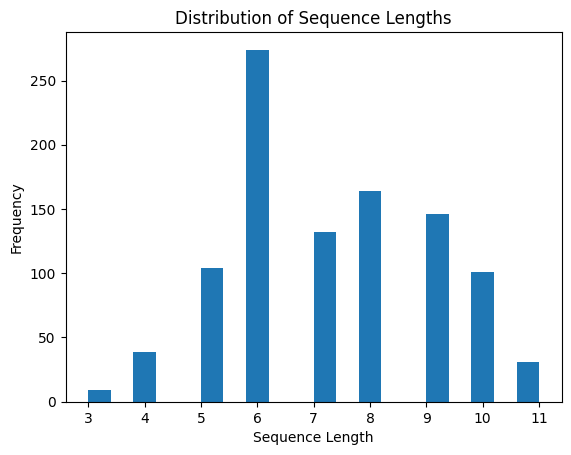

Using maximum sequence length of 11
Training set: 600 samples
Validation set: 200 samples
Test set: 200 samples


In [4]:
# Create sample files for demonstration
sample_corpus_file = "sample_corpus.json"
sample_vocab_file = "sample_vocab.json"

create_sample_corpus(sample_corpus_file)

# Load the corpus
texts, labels = load_corpus(sample_corpus_file)

# Create sample vocabulary file
create_sample_vocabulary(sample_vocab_file, texts)

# Load the vocabulary and create a tokenizer
tokenizer = CustomTokenizer(sample_vocab_file)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Check sequence length distribution
sequence_lengths = [len(seq) for seq in sequences]
plt.hist(sequence_lengths, bins=20)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Determine maximum sequence length (padding/truncating)
max_length = min(max(sequence_lengths), 50)  # Limit to 50 tokens max
print(f"Using maximum sequence length of {max_length}")

# Pad sequences
padded_sequences = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen=max_length,
    padding='post',
    truncating='post',
    value=tokenizer.word_index[tokenizer.pad_token]
)

# Convert labels to numpy array
labels = np.array(labels)

# Split data into train, validation, and test sets
# First split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of total
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

## 5. Building the Model

In [5]:
def build_model(vocab_size, embedding_dim=16, max_length=50):
    """Build a text classification model"""
    model = keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        layers.GlobalAveragePooling1D(),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build the model
model = build_model(vocab_size=tokenizer.num_words, max_length=max_length)
model.summary()

/home/nlarion/Desktop/nlp_html_ads/nlp_html_env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1743186350.291130   25845 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743186350.345363   25845 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743186350.348702   25845 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See m

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 6. Training the Model

Epoch 1/20


I0000 00:00:1743186364.118693   25967 service.cc:146] XLA service 0x7ecb78003eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743186364.118723   25967 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-28 11:26:04.141045: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-28 11:26:04.260147: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5938 - loss: 0.6918

I0000 00:00:1743186365.055361   25967 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7161 - loss: 0.6841 - val_accuracy: 0.9650 - val_loss: 0.6530
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9318 - loss: 0.6405 - val_accuracy: 0.9950 - val_loss: 0.5981
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9361 - loss: 0.5834 - val_accuracy: 1.0000 - val_loss: 0.5266
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9748 - loss: 0.5106 - val_accuracy: 1.0000 - val_loss: 0.4403
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9626 - loss: 0.4371 - val_accuracy: 1.0000 - val_loss: 0.3493
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9591 - loss: 0.3649 - val_accuracy: 1.0000 - val_loss: 0.2646
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9778 - loss: 0.2699 - val_accuracy: 1.0000 - val_loss: 0.1936
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9790 - loss: 0.2161 - val_accuracy: 1.0000 - val_loss: 0.1399
Ep

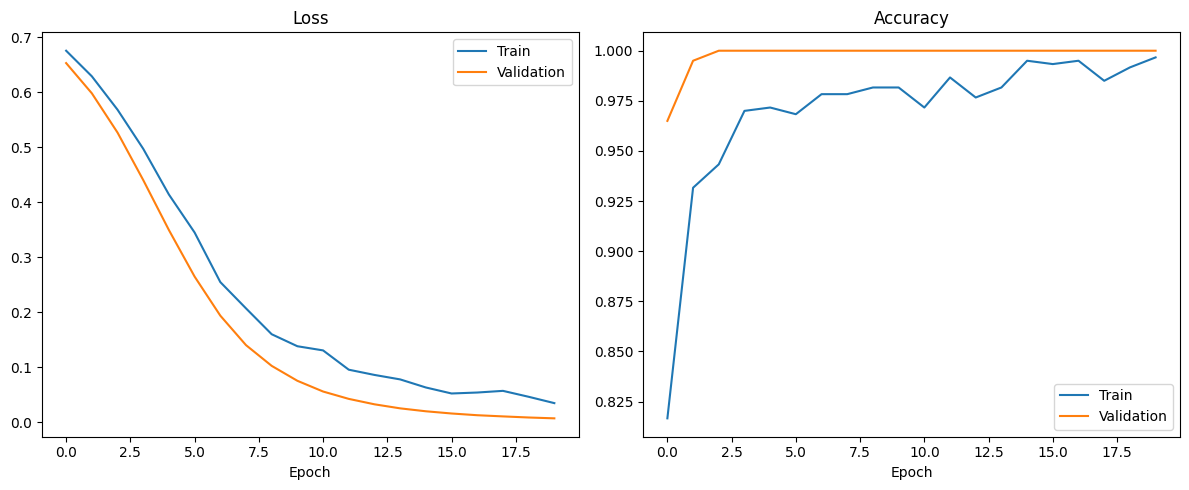

In [6]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Evaluate the Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0072 
Test Loss: 0.0069
Test Accuracy: 1.0000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 

Classification Report:
              precision    recall  f1-score   support

     Not Ads       1.00      1.00      1.00        99
         Ads       1.00      1.00      1.00       101

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



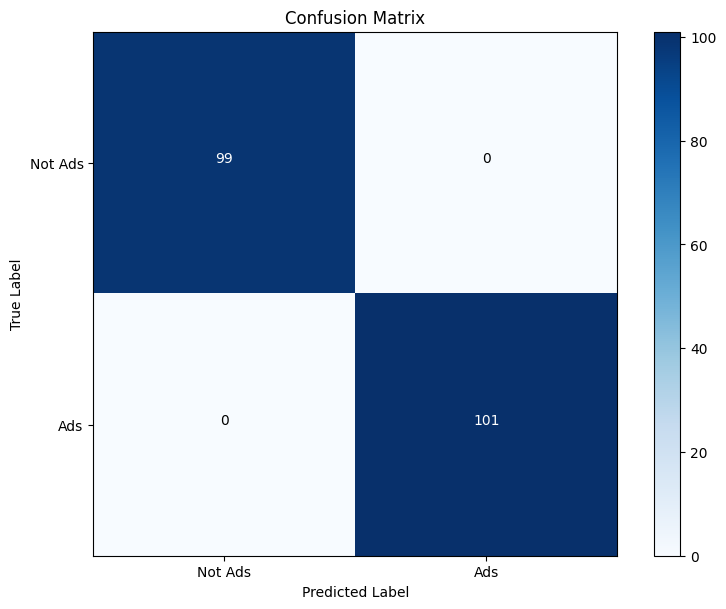

In [7]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Ads', 'Ads']))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Not Ads', 'Ads'])
plt.yticks([0, 1], ['Not Ads', 'Ads'])

# Add labels to the plot
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 8. Test the Model on New Texts

In [8]:
def predict_text(model, tokenizer, text, max_length):
    """Predict class for a single text"""
    # Tokenize text
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded_sequence = keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=max_length,
        padding='post',
        truncating='post',
        value=tokenizer.word_index[tokenizer.pad_token]
    )
    
    # Make prediction
    prediction = model.predict(padded_sequence)[0][0]
    
    # Return result
    is_ad = prediction > 0.5
    label = 'Ad' if is_ad else 'Not Ad'
    confidence = prediction if is_ad else 1 - prediction
    
    return {
        'text': text,
        'label': label,
        'confidence': float(confidence),
        'raw_prediction': float(prediction)
    }

# Test on some new examples
test_texts = [
    "Buy our new shoes with 30% discount today!",
    "The weather is nice today, I'm going for a walk",
    "Limited offer on all electronics this weekend",
    "I watched a great movie yesterday with my friends",
    "This is the best price you will find anywhere"
]

for text in test_texts:
    result = predict_text(model, tokenizer, text, max_length)
    print(f"Text: {result['text']}")
    print(f"Prediction: {result['label']} (confidence: {result['confidence']:.4f})")
    print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Text: Buy our new shoes with 30% discount today!
Prediction: Ad (confidence: 0.9688)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Text: The weather is nice today, I'm going for a walk
Prediction: Not Ad (confidence: 0.9887)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Text: Limited offer on all electronics this weekend
Prediction: Ad (confidence: 0.8251)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Text: I watched a great movie yesterday with my friends
Prediction: Not Ad (confidence: 0.9985)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Text: This is the best price you will find anywhere
Prediction: Not Ad (confidence: 0.7860)
---


## 9. Save Model for TensorFlow.js

In [ ]:
# Make sure you have the tensorflowjs package installed
# !pip install tensorflowjs

# Save the model in Keras format first
model_save_path = "ad_classification_model"
model.save(model_save_path)

# Convert the model to TensorFlow.js format
# This will create a model.json file and binary weight files
tfjs_dir = "tfjs_model"
!mkdir -p {tfjs_dir}

import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, tfjs_dir)

print(f"Model saved in TensorFlow.js format at {tfjs_dir}")

# Save the vocabulary as well
tokenizer.save_vocabulary(f"{tfjs_dir}/vocabulary.json")

## 10. Example JavaScript Code to Use the Model in Browser

In [ ]:
%%writefile tfjs_model/example_usage.js
// Example JavaScript code to use the model in a browser
// Note: This is just an example and would need to be adapted to your specific use case

// Load the model
async function loadModel() {
  const model = await tf.loadLayersModel('model.json');
  return model;
}

// Load the vocabulary
async function loadVocabulary() {
  const response = await fetch('vocabulary.json');
  const vocab = await response.json();
  return vocab;
}

// Tokenize and pad text
function tokenize(text, vocab, maxLength) {
  // Convert to lowercase and remove punctuation
  const cleanText = text.toLowerCase().replace(/[^\w\s]/g, '');
  
  // Split into words
  const words = cleanText.split(/\s+/);
  
  // Convert words to indices
  const oovIndex = vocab['<OOV>'] || 1;
  const sequence = words.map(word => vocab[word] || oovIndex);
  
  // Truncate or pad as needed
  const padIndex = vocab['<PAD>'] || 0;
  
  if (sequence.length > maxLength) {
    return sequence.slice(0, maxLength);
  } else {
    const padding = Array(maxLength - sequence.length).fill(padIndex);
    return [...sequence, ...padding];
  }
}

// Predict class for text
async function predictText(text) {
  // Load model and vocabulary
  const [model, vocab] = await Promise.all([loadModel(), loadVocabulary()]);
  
  // Define max length
  const maxLength = 50;
  
  // Tokenize text
  const sequence = tokenize(text, vocab, maxLength);
  
  // Create tensor
  const inputTensor = tf.tensor2d([sequence], [1, maxLength]);
  
  // Make prediction
  const outputTensor = model.predict(inputTensor);
  const prediction = await outputTensor.data();
  
  // Cleanup
  inputTensor.dispose();
  outputTensor.dispose();
  
  // Return result
  const isAd = prediction[0] > 0.5;
  const label = isAd ? 'Ad' : 'Not Ad';
  const confidence = isAd ? prediction[0] : 1 - prediction[0];
  
  return {
    text,
    label,
    confidence,
    rawPrediction: prediction[0]
  };
}

// Example usage
async function main() {
  const texts = [
    "Buy our new shoes with 30% discount today!",
    "The weather is nice today, I'm going for a walk"
  ];
  
  for (const text of texts) {
    const result = await predictText(text);
    console.log(`Text: ${result.text}`);
    console.log(`Prediction: ${result.label} (confidence: ${result.confidence.toFixed(4)})`);
    console.log('---');
  }
}

// Call main when document is loaded
document.addEventListener('DOMContentLoaded', main);

## 11. Summary

In this notebook, we have:

1. Created a custom tokenizer that can load vocabulary from a JSON file
2. Loaded a corpus from a JSON file (or created a sample one)
3. Preprocessed the text data for NLP classification
4. Built and trained a TensorFlow model to classify texts as "ads" or "not ads"
5. Evaluated the model's performance
6. Saved the model in a format compatible with TensorFlow.js
7. Provided example JavaScript code to use the model in a browser

The key components that satisfy the requirements are:
- Custom tokenizer with JSON vocabulary loading (Section 2)
- Corpus loading from JSON (Section 3)
- Binary classification for "ads" and "not ads" (Sections 5-7)
- Model export for TensorFlow.js (Section 9)

For a real-world application, you may want to consider:
- Using a more sophisticated model architecture (e.g., LSTM, Transformer)
- Using pre-trained word embeddings
- Implementing more advanced text preprocessing
- Collecting a larger and more diverse dataset
- Adding more classes if needed